# Neural Network

In the previous exercise, we implemented feedforward propagation for neural networks and used it to predict handwritten digits with the provided weights. In this exercise, we will implement the backpropagation algorithm
to learn the parameters for the neural network.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
data = loadmat('Datasets/ex4data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [3]:
y = data['y']
X = np.c_[np.ones((data['X'].shape[0],1)), data['X']]

print('X:',X.shape, 'The data contains 400 features(20x20) + intercept and 5000 record')
print('y:',y.shape)

X: (5000, 401) The data contains 400 features(20x20) + intercept and 5000 record
y: (5000, 1)


In [10]:
weights = loadmat('Datasets/ex3weights.mat')
weights.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [11]:
theta1, theta2 = weights['Theta1'], weights['Theta2']

print('theta1: {}'.format(theta1.shape))
print('theta2: {}'.format(theta2.shape))

theta1: (25, 401)
theta2: (10, 26)


## Display Digits

In [4]:
def DisplayDigits(X):
##This function aims to plot 100 randomly picked digits
    width, height = 20, 20
    nrows, ncols = 10, 10
    indices_to_display = np.random.choice(range(X.shape[0]), nrows * ncols)

    big_picture = np.zeros((height * nrows, width * ncols))

    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol = 0
        iimg = X[idx].reshape(width, height).T # transpose the data set
        big_picture[irow * height:irow * height + iimg.shape[0], icol * width:icol * width + iimg.shape[1]] = iimg
        icol += 1
        
        
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(big_picture,cmap=plt.cm.Greys_r)
    plt.axis('off')

    plt.show() 

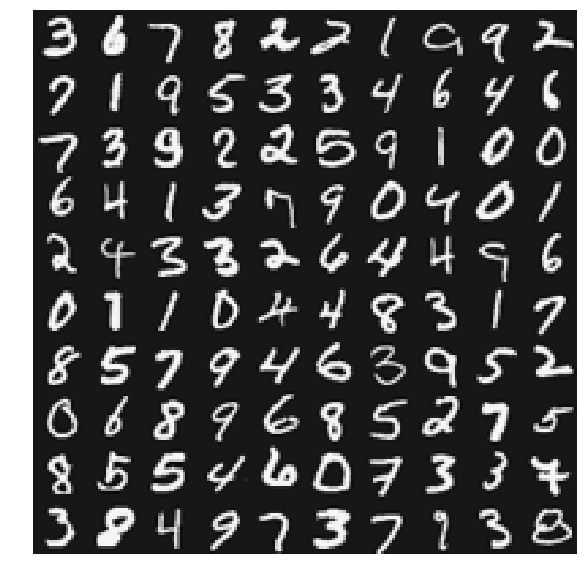

In [5]:
DisplayDigits(X[:,1:])

## 1- Feedforward and cost function

In [6]:
def sigmoid (z):
    return (1/(1 + np.exp(-z)))

In [7]:
def Feedforward(theta1, theta2 , x):
    z2= np.dot(x, theta1.T)
    a2= sigmoid(z2)
    a2 = np.insert(a2,0,1,axis=1)
    z3= np.dot(a2, theta2.T)
    a3 = sigmoid(z3)
    
    return a2 , a3

def results (a3):
    return (np.argmax(a3, axis=1)+1) 

In [8]:
def costFunction(a3 , y, theta1 , theta2, regPar ):
    m= a3.shape[0]
    y_dummy = pd.get_dummies(y.ravel()).as_matrix() 
    cost =0
    for i in range (a3.shape[1]):
        cost += -1*(1/m)*((np.log(a3[:,i])*(y_dummy[:,i])+np.log(1-a3[:,i])*(1-y_dummy[:,i]))) 
    
    cost = sum(cost) + (regPar/(2*m))*(np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:])))
    return cost

In [20]:
a2 , a3 = Feedforward(theta1, theta2 , X)
cost1 = costFunction(a3, y, theta1 , theta2, 0)
print ('cost value when regPar is zero', cost1)

cost2 = costFunction(a3, y, theta1 , theta2, 1)
print ('cost value when regPar is one', cost2)

cost value when regPar is zero 0.28762916516131876
cost value when regPar is one 0.3837698590909235


## 2- Backpropagation

### 2.1- Sigmoid gradient

In [21]:
def Sigmoid_gradient(z):
    return sigmoid(z)*(1-sigmoid(z))

### 2.2-Random initialization 

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking.

In [29]:
def randInitializeWeights(layer1, layer2):
    
    w= np.zeros([layer1, layer2])
    epsilon = 0.12
    W = np.random.rand(layer1, layer2) * 2 * epsilon - epsilon
    
    return W


In [30]:
initial_theta1= randInitializeWeights(theta1.shape[0], theta1.shape[1])
initial_theta2= randInitializeWeights(theta2.shape[0], theta2.shape[1])

### 2.3 - Backpropagation

In [31]:
def BackPropagation(a1,a2,a3,theta1,theta2 , regPar):
    z3 = sigmoid(np.dot(a2, theta2.T))
    
    z2 = sigmoid(np.dot(a1, theta1.T))
    m= a3.shape[0]
    
    y_dummy = pd.get_dummies(y.ravel()).as_matrix() 

    s3 = a3 - y_dummy # 5000x10
    s2 = theta2[:,1:].T.dot(s3.T)*Sigmoid_gradient(z2).T # 25x10 *10x5000 * 25x5000 = 25x5000
    
    del1 = s2.dot(a1) # 25x5000 * 5000x401 = 25x401
    del2 = s3.T.dot(a2) # 10x5000 *5000x26 = 10x26
    
    th1 = theta1[:,1:]
    th2 = theta2[:,1:]
    ######
    
    grad11 = del1[:,0]/m
    grad12 = del1[:,1:]/m + (th1*regPar)/m
    
    grad1= np.c_[ grad11 , grad12 ]
    
    ##### 
    
    grad21 = del2[:,0]/m
    grad22 = del2[:,1:]/m + (th2*regPar)/m
    
    grad2 = np.c_[ grad21 , grad22 ]
    
    
    
    return grad1, grad2

### 2.4 - Gradient Check 